In [ ]:
%matplotlib notebook
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/DATA/shared')

In [2]:
tf.reset_default_graph()

from models import inception_v4
from nets import inception_utils

In [3]:
inception_v4.inception_v4.default_image_size

299

In [4]:
def read_data(filename_queue): #, shape=(32, 32, 3)):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(serialized_example,
                                       features={
            'image/encoded': tf.FixedLenFeature([], tf.string),
            'image/class/label': tf.FixedLenFeature([], tf.int64),
            'image/width': tf.FixedLenFeature([], tf.int64),
            'image/height': tf.FixedLenFeature([], tf.int64)
            })
    
    # Note: decode_jpeg returns image size, decode_image does NOT.
    image = tf.image.decode_jpeg(features['image/encoded'], channels=3)
    return image, features['image/class/label']

In [5]:
with tf.device('/gpu:0'):
    filename_queue = tf.train.string_input_producer(
        #tf.gfile.Glob('/DATA/shared/datasets/flowers/flowers_validation_*-of-00005.tfrecord'))
        tf.gfile.Glob('/DATA/shared/datasets/flowers/flowers_train_*-of-00005.tfrecord'))
    image, label = read_data(filename_queue)
    image = tf.image.resize_images(image, (299, 299))

    batch_size = 16
    images, sparse_labels = tf.train.shuffle_batch(
        [image, label], batch_size=batch_size, num_threads=2,
        capacity=1000 + 3 * batch_size,
        min_after_dequeue=1000)
    
    images = (tf.cast(images, tf.float32) - 128.0) / 33.0
    
    with tf.contrib.framework.arg_scope(inception_utils.inception_arg_scope()):
         m = inception_v4.inception_v4(images, num_classes=17, is_training=False, create_aux_logits=True)
    
    logits = m[0]
    xent = tf.losses.sparse_softmax_cross_entropy(sparse_labels, logits)
    loss = tf.reduce_mean(xent, name='cross_entropy')

In [6]:
with tf.device('/gpu:0'):

    filename_test_queue = tf.train.string_input_producer(
            tf.gfile.Glob('/DATA/shared/datasets/flowers/flowers_validation_*-of-00005.tfrecord')
                )
    image_test, label_test = read_data(filename_test_queue)
    image_test = tf.image.resize_images(image_test, (299, 299))

    batch_size = 16
    images_test, sparse_labels_test = tf.train.shuffle_batch(
        [image_test, label_test], batch_size=batch_size, num_threads=2,
        capacity=1000 + 3 * batch_size,
        min_after_dequeue=1000)
    
    images_test = (tf.cast(images_test, tf.float32) - 128.0) / 33.0


In [7]:
logits,sparse_labels

(<tf.Tensor 'InceptionV4/Logits/Logits/BiasAdd:0' shape=(16, 17) dtype=float32>,
 <tf.Tensor 'shuffle_batch:1' shape=(16,) dtype=int64>)

In [8]:
# Skip the last logits layer, which depends on the number of classes.
saver = tf.train.Saver([t for t in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='InceptionV4')
                        if 'Logits' not in t.name])

In [9]:
var_list = [t for t in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if 'Conv' not in t.name] 

In [10]:
len(var_list)

4

In [11]:
opt = tf.train.RMSPropOptimizer(learning_rate=0.001)
train_op = opt.minimize(loss,var_list=var_list)


In [12]:
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
sess.run(init_op)
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

In [13]:
sess.run(images).shape

(16, 299, 299, 3)

In [14]:
sess.run(image).shape

(299, 299, 3)

<IPython.core.display.Javascript object>


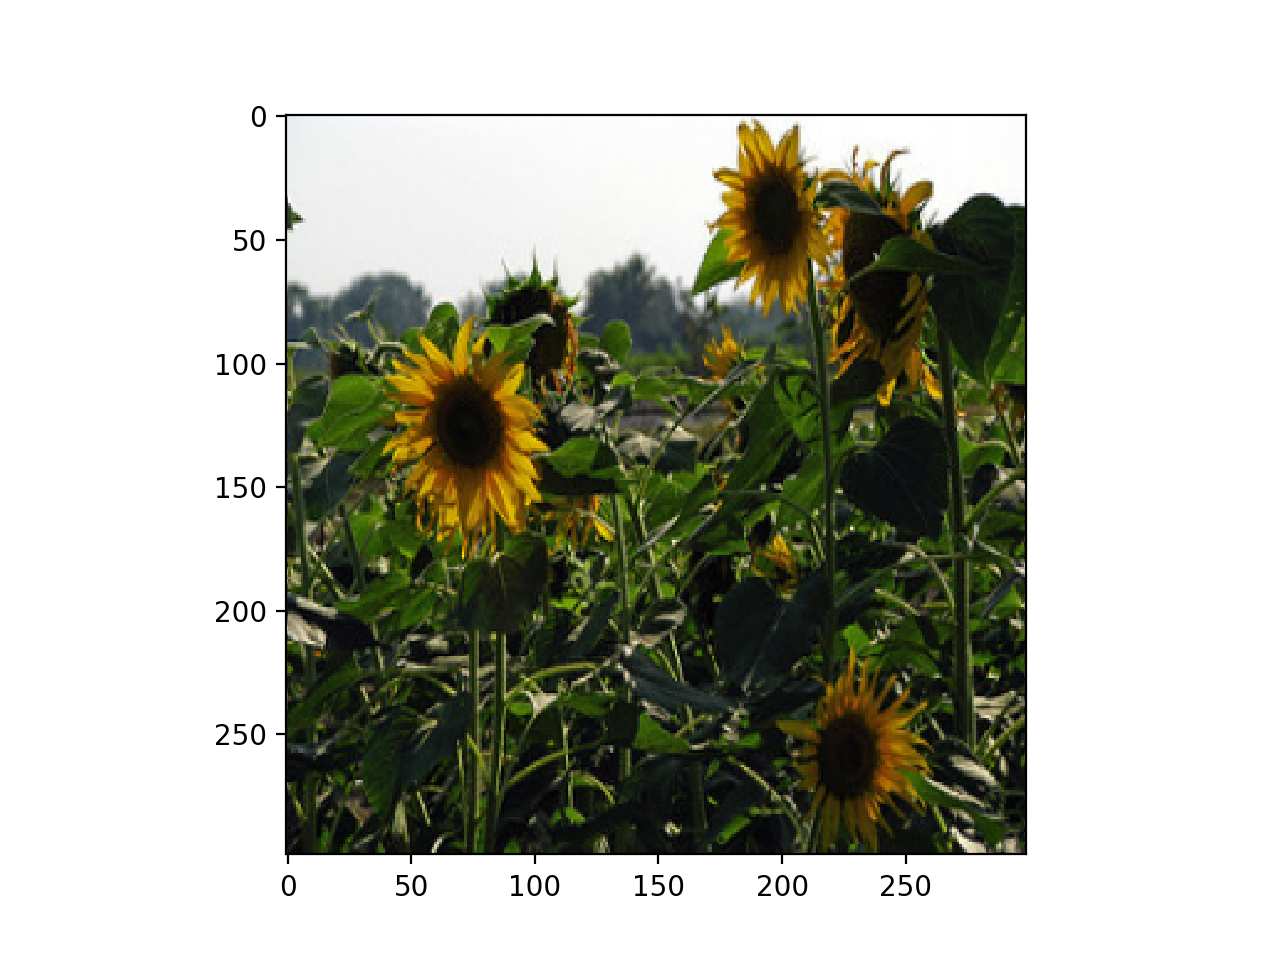

In [34]:
plt.imshow((sess.run(image)).astype(np.uint8) )

In [16]:
%%time 
saver.restore(sess, '/DATA/shared/models/inception_v4.ckpt')

CPU times: user 1.62 s, sys: 1.91 s, total: 3.54 s
Wall time: 832 ms


<IPython.core.display.Javascript object>


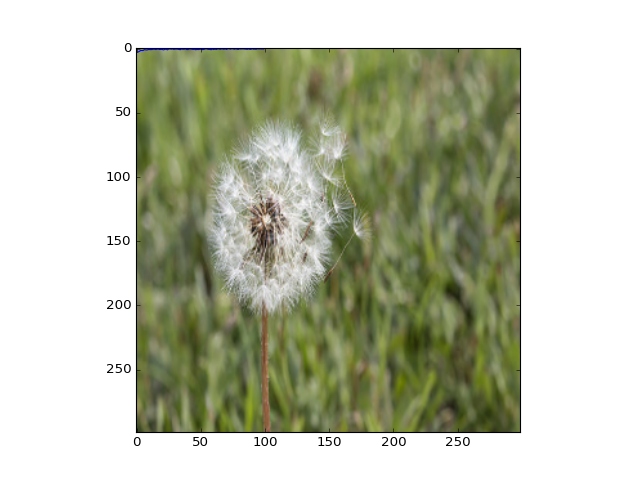

CPU times: user 12min 31s, sys: 1min 23s, total: 13min 54s
Wall time: 8min 16s


In [18]:
%%time 
lvals = []
fig,ax = plt.subplots(1,1)

for i in range(1000):
    l, _ = sess.run([loss, train_op])
    if i % 10 == 0:
        lvals.append(l)
        ax.clear()
        ax.plot(lvals)
        fig.canvas.draw()



Aby zapisać "dotrenowanie" modelu można stowrzyć nowy "saver" ,tym razem dla wszystkich zmiennych w grafie:


```python
saver = tf.train.Saver()
saver.save(sess, '....ckpt')
```

 i go poten odtworzyć:

```python
saver = tf.train.Saver()
saver.restore(sess, '....ckpt')
```

In [18]:
l2name = {0:"daisy",1:"dandelion",2:"roses",3:"sunflowers",4:"tulips"}

In [19]:
M,Imgs,Labels = sess.run([m,images,sparse_labels])

In [20]:
np.argmax(M[0],axis=-1)

array([2, 1, 2, 3, 2, 1, 2, 1, 4, 1, 0, 3, 3, 3, 1, 3])

In [21]:
Labels

array([2, 3, 2, 3, 2, 1, 2, 1, 1, 1, 0, 3, 3, 3, 1, 3])

In [22]:
np.sum(np.argmax(M[0],axis=-1)==Labels)/np.size(Labels)

0.875

In [23]:
l2name[Labels[0]]

'roses'

<IPython.core.display.Javascript object>


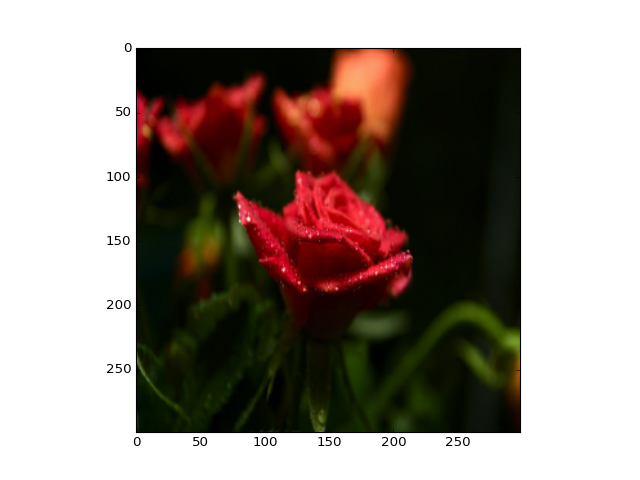

In [24]:
plt.imshow((33*Imgs[0]+128).astype(np.uint8))

## Na danych test

In [25]:
Images_test,Labels_test = sess.run([images_test, sparse_labels_test])


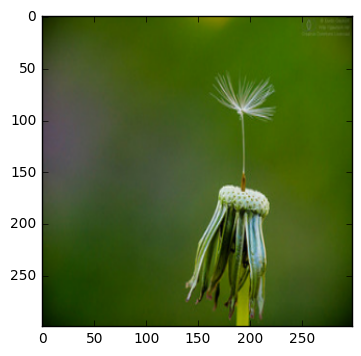

In [26]:
%matplotlib inline 
plt.imshow((128+33*Images_test[12]).astype(np.uint8))

In [27]:
l2name[Labels_test[12]],Labels_test[12]

('dandelion', 1)

In [28]:
Labels_test

array([4, 0, 0, 4, 0, 1, 3, 4, 1, 1, 0, 4, 1, 2, 3, 3])

In [29]:
M = sess.run(m,feed_dict={images:Images_test})

In [30]:
np.argmax(M[0],axis=-1)

array([4, 2, 0, 4, 0, 1, 3, 2, 1, 0, 0, 4, 1, 4, 3, 2])

In [31]:
np.sum(np.argmax(M[0],axis=-1)==Labels_test)/np.size(Labels_test)

0.6875

roses daisy


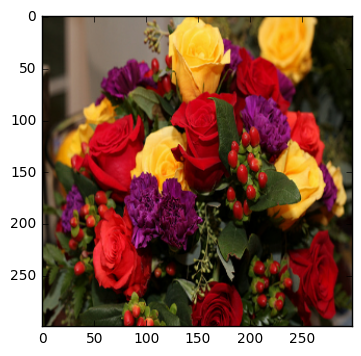

In [32]:
ith=4
plt.imshow((33*Imgs[ith]+128).astype(np.uint8))
print(l2name[Labels[ith]],l2name[np.argmax(M[0][ith],axis=-1)])

## 

In [40]:
[t.name for t in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if 'Conv' not  in t.name] 

['InceptionV4/AuxLogits/Aux_logits/weights:0',
 'InceptionV4/AuxLogits/Aux_logits/biases:0',
 'InceptionV4/Logits/Logits/weights:0',
 'InceptionV4/Logits/Logits/biases:0']

In [43]:
[t.name for t in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if 'Logit'  in t.name] 

['InceptionV4/AuxLogits/Conv2d_1b_1x1/weights:0',
 'InceptionV4/AuxLogits/Conv2d_1b_1x1/BatchNorm/beta:0',
 'InceptionV4/AuxLogits/Conv2d_2a/weights:0',
 'InceptionV4/AuxLogits/Conv2d_2a/BatchNorm/beta:0',
 'InceptionV4/AuxLogits/Aux_logits/weights:0',
 'InceptionV4/AuxLogits/Aux_logits/biases:0',
 'InceptionV4/Logits/Logits/weights:0',
 'InceptionV4/Logits/Logits/biases:0']

In [36]:
len( [t.name for t in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if 'Conv'  in t.name]) 

302